<a href="https://colab.research.google.com/github/eabdelbadea/ML-TASK-IMAGES/blob/main/Elsayed_202201458_Custom_transfer_learning_CNN_lite_model_for_flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



#Assignement1
#Student Code: 202201458
#Student Name: السيد عبدالبديع محمد
# Below is the explanation of handling the overfitting Issue

##1################# Technique 1 - Using Dropout
- it is a regularization technique used to prevent overfitting by randomly deactivating a fraction of neurons during training
- During training, Dropout randomly sets a fraction of input units to 0 at each update cycle, This helps prevent overfitting by forcing the network to learn more robust features
- It will be used between Dense() layers.
- We insert Dropout() layers with a dropout rate (fraction of neurons to drop during training).

##2################# Technique 2 - Using early stop
- Early stopping is a technique used to prevent overfitting by monitoring the performance of a model on a validation dataset during training and stopping the training process when the performance stops improving or starts to degrade.
- We will add the callbacks argument with the fit() method.
- The callback monitors the validation loss (monitor='loss') and waits for a certain number of epochs (patience=3 ) without improvement before stopping the training process. The argument 'restore_best_weights' ensures that the weights of the model are restored to the ones that achieved the best performance on the validation set.

##3################# Technique 3 - Using L2 regularization
- Regularization is a technique used to prevent overfitting by adding a penalty term to the loss function, discouraging overly complex models.
- There are different types of regularization techniques, including L2 Regularization (Ridge), L2 regularization adds a penalty term to the loss function proportional to the square of the coefficients of the model. It penalizes large weights and tends to produce models with smaller weights.
- In my example, with Dense() layers, I will include the kernel_regularizer argument to apply L2 regularization to the weights of the layers. The value 0.01 represents the regularization strength.

##4################# Added below parts before Convert the Keras model to TensorFlow

4.1-Upload Images to test from colab
4.2 Definition of image Processing to test the model by Display the image with the predected Label

##5################# Comment for quantization modification
when using quantization to covert the model to TF Lite, i will add below command to get better accurcy when testing with mobile app: converter.target_spec.supported_types = [tf.float16]



the result from the colab

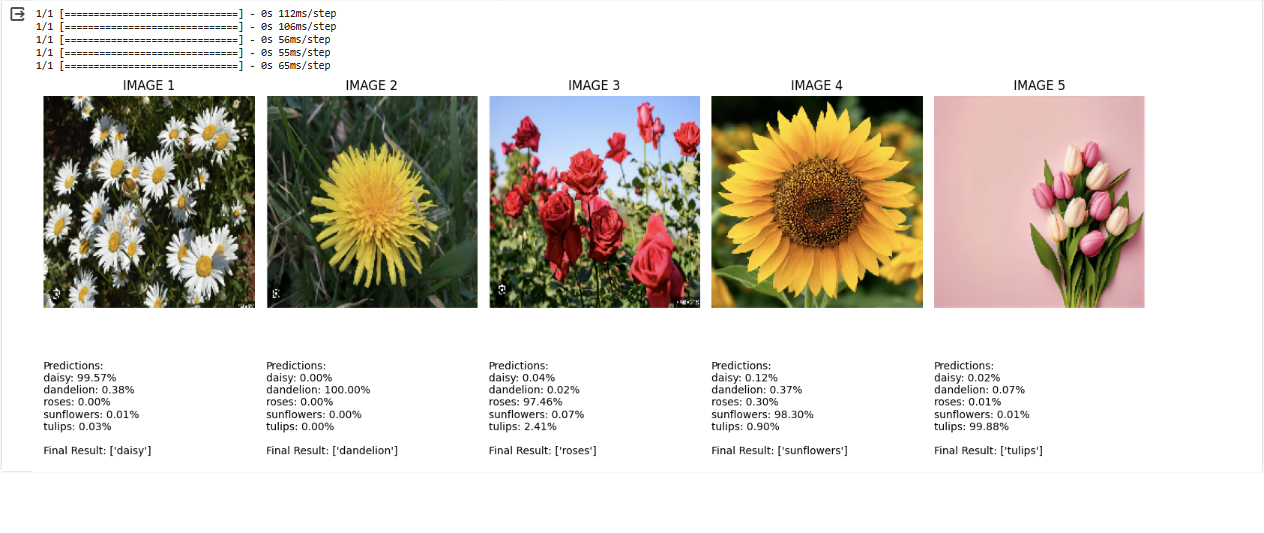


the result from the colab




In [1]:
# @title The result from Mobile


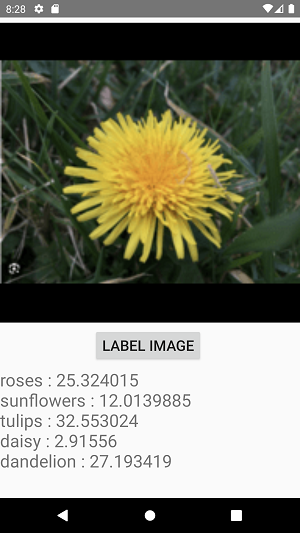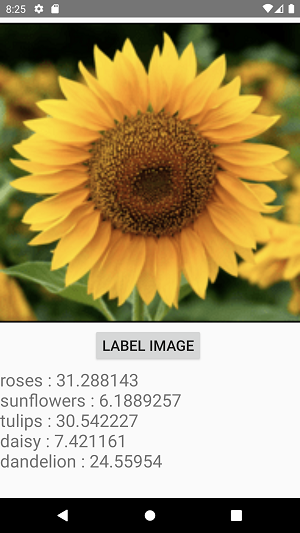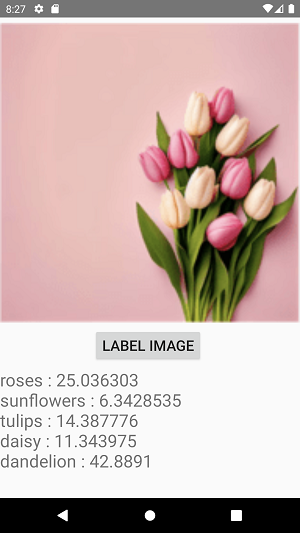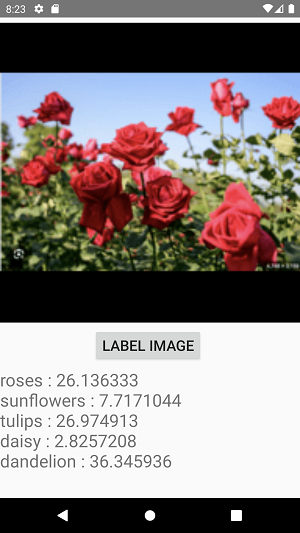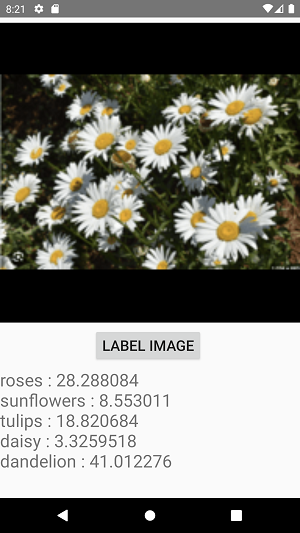

In [2]:
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE

Tensorflow version 2.15.0


In [3]:
GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec'
IMAGE_SIZE = [192, 192]

BATCH_SIZE = 64 # 128 works on GPU too but comes very close to the memory limit of the Colab GPU
EPOCHS = 40

VALIDATION_SPLIT = 0.19
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # do not change, maps to the labels in the data (folder names)

# gel list of flowers files and split data files between training and validation
filenames = tf.io.gfile.glob(GCS_PATTERN)
# get index at which data split begin
split = int(len(filenames) * VALIDATION_SPLIT)
# get list of training files ( from index 0 to index = split)
training_filenames = filenames[split:]
# get list of validation files ( from index = split to end of list )
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))

#
validation_steps = int(3670 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 64, there will be 46 batches per training epoch and 10 batch(es) per validation run.


In [4]:
#@title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)

  for images, labels in dataset:
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    break;

  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1

def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[labels[i]]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;

  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;

  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    #plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

In [5]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.io.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size will be needed for TPU
    class_label = example['class']
    return image, class_label

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, read from multiple
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
  return dataset

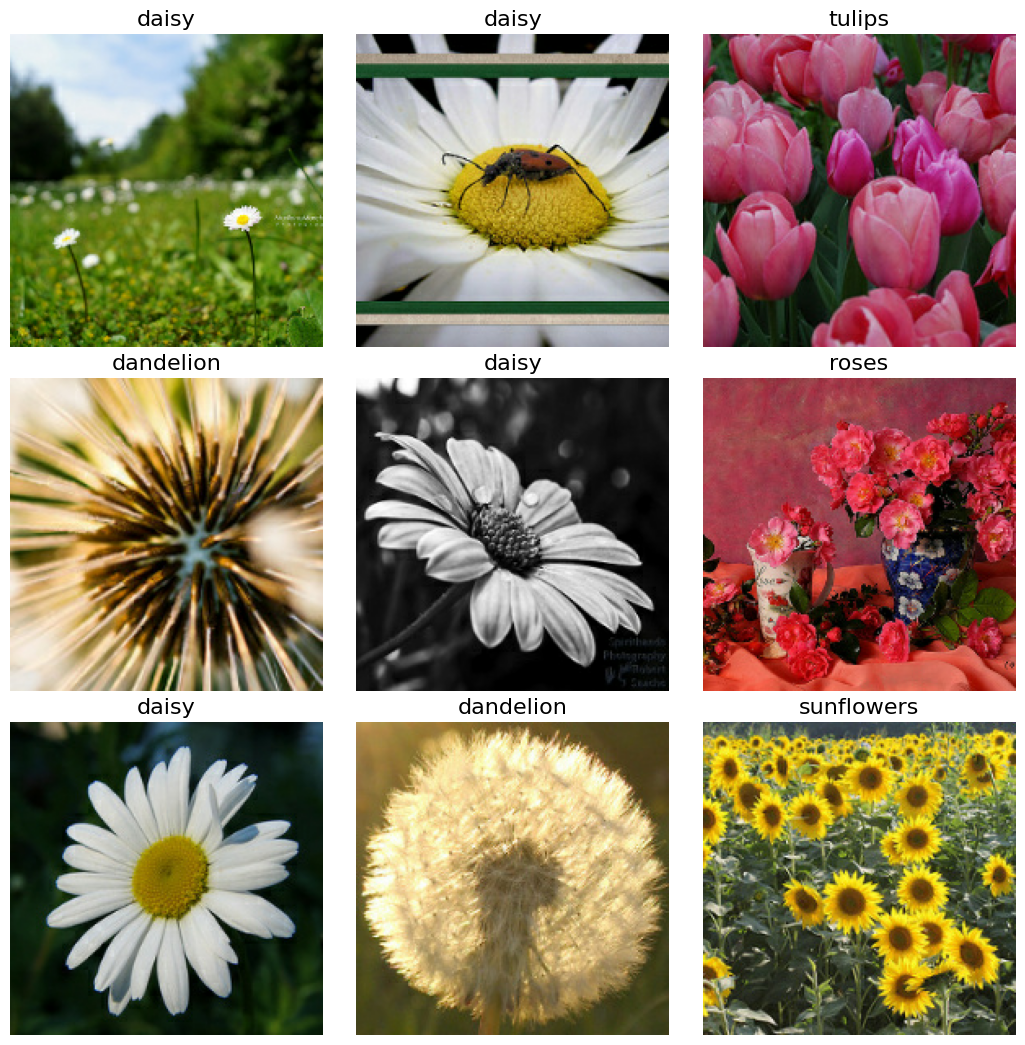

In [6]:
display_9_images_from_dataset(load_dataset(training_filenames))

@title the result from colab

## training and validation datasets

In [7]:
def get_batched_dataset(filenames, train=False):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  if train:
    # Best practices for Keras:
    # Training dataset: repeat then batch
    # Evaluation dataset: do not repeat
    dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTOTUNE) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset
  # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

# instantiate the datasets
training_dataset = get_batched_dataset(training_filenames, train=True)
validation_dataset = get_batched_dataset(validation_filenames, train=False)

In [8]:
import os

import numpy as np

import tensorflow as tf
assert tf.__version__.startswith('2')

import matplotlib.pyplot as plt

image_path = tf.keras.utils.get_file(
      'flower_photos.tgz',
      'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
      extract=True)
image_path = os.path.join(os.path.dirname(image_path), 'flower_photos')

228813984/228813984 [==============================] - 1s 0us/step


In [9]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
#pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


## Model [WORK REQUIRED HERE]

In [10]:
### QUESTION 1


from tensorflow.keras import regularizers

model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(input_shape=(192, 192)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),   # Dropout rate of 50% of neurons will be randomly deactivated during training
    tf.keras.layers.Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),  # Another Dropout layer
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_192 (Func  (None, 6, 6, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 46080)             0         
                                                                 
 dense (Dense)               (None, 128)               5898368   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 20)                2580      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                        

## Training

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
#Define early stopping callback
early_stopping =EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=validation_steps, callbacks=[early_stopping]) # adding callback

Epoch 1/40
46/46 [==============================] - 29s 263ms/step - loss: 5.5465 - accuracy: 0.3312 - val_loss: 3.7769 - val_accuracy: 0.6328
Epoch 2/40
46/46 [==============================] - 4s 92ms/step - loss: 3.7774 - accuracy: 0.4504 - val_loss: 2.7695 - val_accuracy: 0.7688
Epoch 3/40
46/46 [==============================] - 4s 81ms/step - loss: 2.8684 - accuracy: 0.5577 - val_loss: 2.2430 - val_accuracy: 0.7703
Epoch 4/40
46/46 [==============================] - 4s 85ms/step - loss: 2.3889 - accuracy: 0.6016 - val_loss: 1.8643 - val_accuracy: 0.8203
Epoch 5/40
46/46 [==============================] - 4s 81ms/step - loss: 2.0399 - accuracy: 0.6566 - val_loss: 1.6487 - val_accuracy: 0.8016
Epoch 6/40
46/46 [==============================] - 4s 81ms/step - loss: 1.8129 - accuracy: 0.6702 - val_loss: 1.3983 - val_accuracy: 0.8313
Epoch 7/40
46/46 [==============================] - 4s 86ms/step - loss: 1.5959 - accuracy: 0.7143 - val_loss: 1.3528 - val_accuracy: 0.8234
Epoch 8/40


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<ipython-input-4-a4859c1ed5bf>:57: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


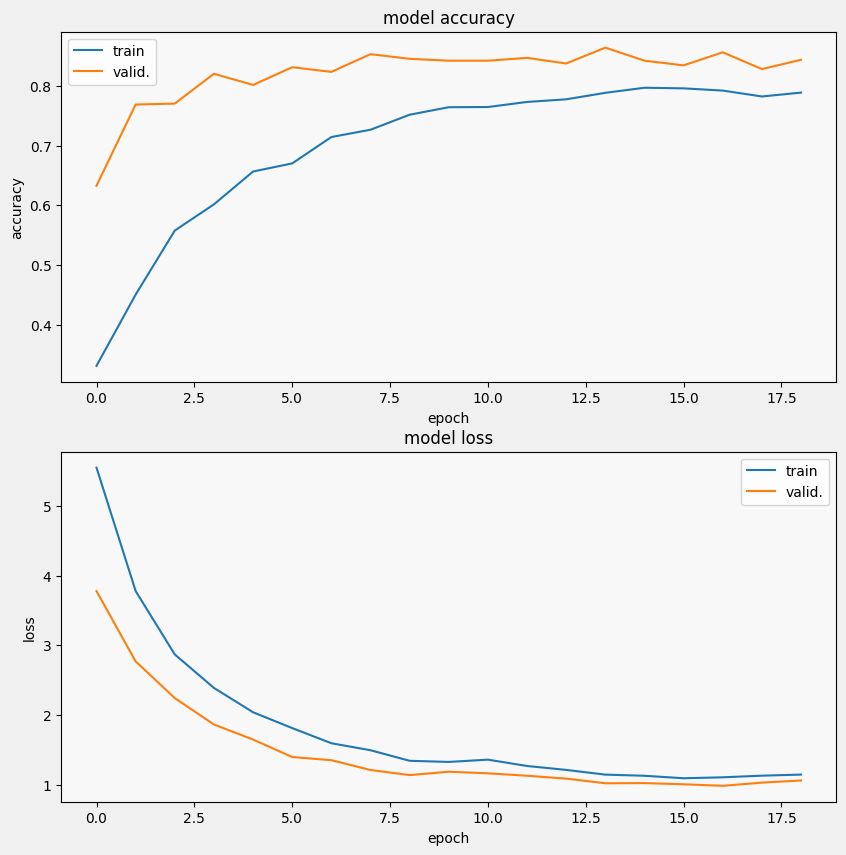

In [12]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

## Predictions

In [13]:
# random input: execute multiple times to change results
flowers, labels = dataset_to_numpy_util(load_dataset(validation_filenames).skip(np.random.randint(300)), 9)

predictions = model.predict(flowers, steps=1)
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())

1/1 [==============================] - 2s 2s/step
['roses', 'tulips', 'sunflowers', 'dandelion', 'tulips', 'sunflowers', 'dandelion', 'dandelion', 'daisy']


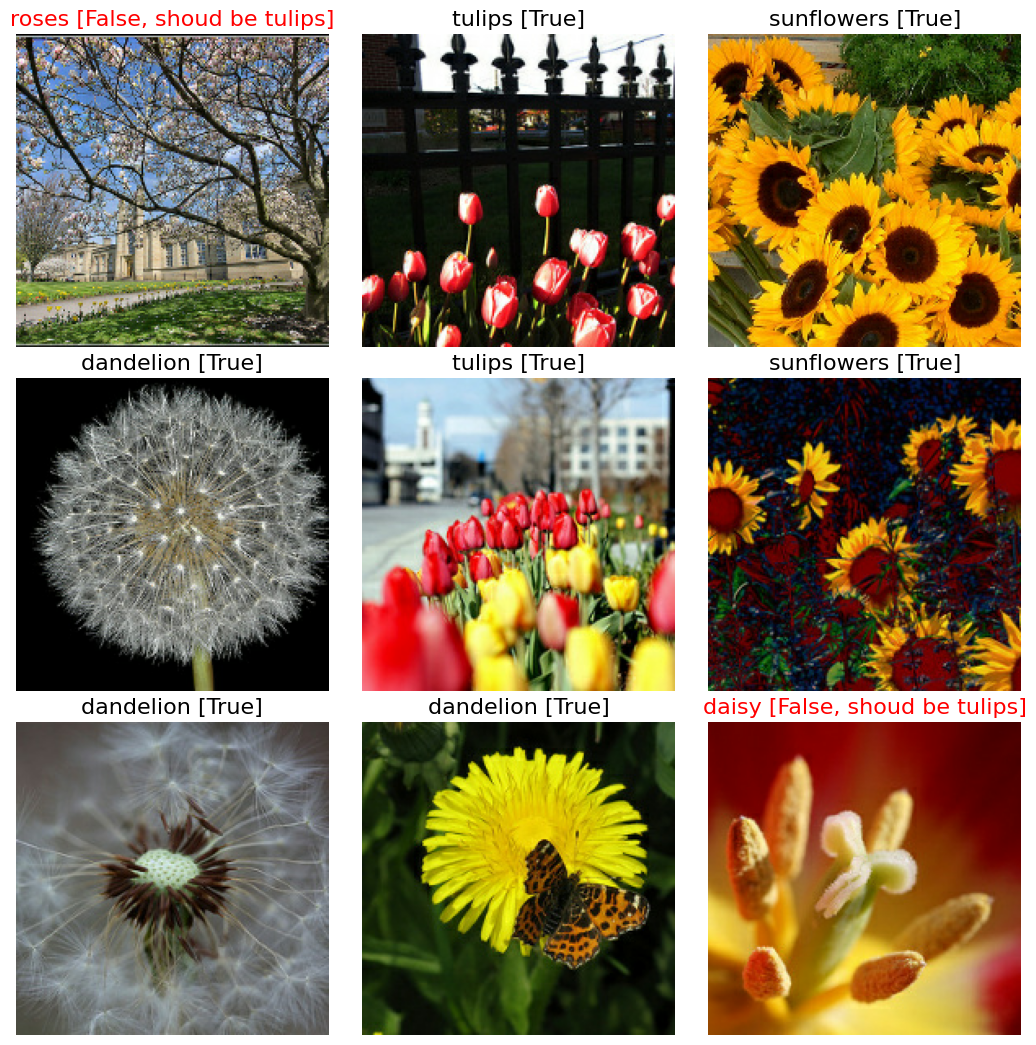

In [14]:
display_9_images_with_predictions(flowers, predictions, labels)

In [15]:
# @title Upload Images to test from colab
# Elsayed 08052024
import urllib.request

image_url = 'https://raw.githubusercontent.com/eabdelbadea/ML-TASK-IMAGES/main/flower1.png'
urllib.request.urlretrieve(image_url, '/content/flower1.png')

image_url = 'https://raw.githubusercontent.com/eabdelbadea/ML-TASK-IMAGES/main/flower2.png'
urllib.request.urlretrieve(image_url, '/content/flower2.png')

image_url = 'https://raw.githubusercontent.com/eabdelbadea/ML-TASK-IMAGES/main/flower3.png'
urllib.request.urlretrieve(image_url, '/content/flower3.png')

image_url = 'https://raw.githubusercontent.com/eabdelbadea/ML-TASK-IMAGES/main/flower4.png'
urllib.request.urlretrieve(image_url, '/content/flower4.png')

image_url = 'https://raw.githubusercontent.com/eabdelbadea/ML-TASK-IMAGES/main/flower5.png'
urllib.request.urlretrieve(image_url, '/content/flower5.png')

('/content/flower5.png', <http.client.HTTPMessage at 0x7edd9971c640>)

1/1 [==============================] - 0s 21ms/step


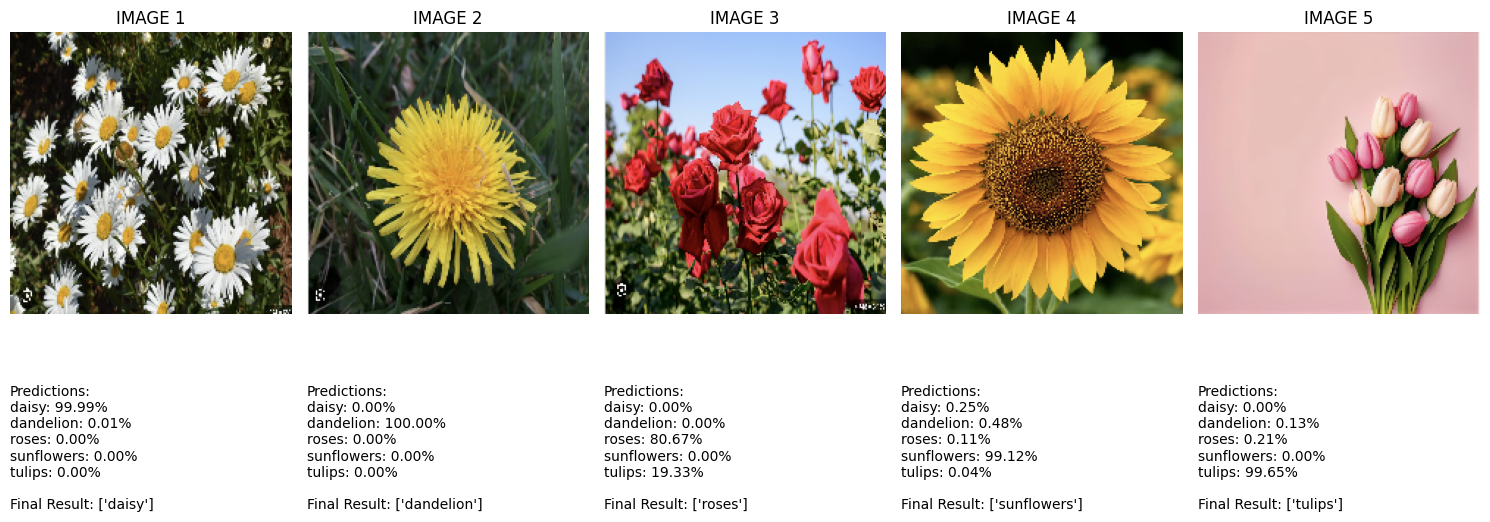

In [16]:
# @title Result of Testing Model Before Convert Model to TensorFlow Lite
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Elsayed 08052024
# Definition of image Processing
def imageProcessing(imagepath):
    output = ""

    img = tf.keras.preprocessing.image.load_img(imagepath, target_size=(192, 192))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)

    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    predictions = model.predict(img_array)

    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)

    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    img_pil = tf.keras.preprocessing.image.array_to_img(img_array[0])

    predictions_array = np.array(predictions)
    predictions_arrays = np.array(predictions[0])

    output += 'Predictions:\n'
    for i in range(5):
        output += f'{CLASSES[i]}: {predictions_arrays[i]*100:.2f}%\n'

    output += '\nFinal Result: ' + ''.join(str(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist()))

    return img_pil, output

# Create a single figure with multiple subplots
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

# Process each image and display it in a subplot
for i, ax in enumerate(axes):
    ax.set_title(f'IMAGE {i+1}')
    processed_image, prediction_text = imageProcessing(f'/content/flower{i+1}.png')
    ax.imshow(processed_image)
    ax.axis('off')
    ax.text(0, -0.25, prediction_text, transform=ax.transAxes, fontsize=10, va='top')

plt.tight_layout()
plt.show()

## Convert the Keras model to TensorFlow Lite
Now as we have trained the digit classifer model, we will convert it to TensorFlow Lite format for mobile deployment.


In [17]:
model.export("models")

# Convert Keras model to TF Lite format.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

# Show model size in KBs.
float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

Saved artifact at 'models'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 192, 192, 3), dtype=tf.float32, name='mobilenetv2_1.00_192_input')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  139490236193552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139490236199184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139490236200416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139490236201648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139492357177408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139490236190208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139490236195664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139492357181280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139492357184096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139492357179168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1394923571

*As* we will deploy our model to a mobile device, we want our model to be as small and as fast as possible. **Quantization** is a common technique often used in on-device machine learning to shrink ML models. Here we will use 8-bit number to approximate our 32-bit weights, which in turn shrinks the model size by a factor of 4.

See [TensorFlow documentation](https://www.tensorflow.org/lite/performance/post_training_quantization) to learn more about other quantization techniques.

In [18]:
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float32]  # added to get better accuracy on mobile
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

Quantized model size = 31710KBs,
which is about 100% of the float model size.


## Evaluate the TensorFlow Lite model

By using quantization, we often traded off a bit of accuracy for the benefit of having a significantly smaller model. Let's calculate the accuracy drop of our quantized model.

## Download the TensorFlow Lite model

Let's get our model and integrate it into an Android app.

If you see an error when downloading mnist.tflite from Colab, try running this cell again.

In [19]:
# Save the quantized model to file to the Downloads directory
f = open('flowersElsayed4.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

# Download the digit classification model
from google.colab import files
files.download('flowersElsayed4.tflite')

print('`flowersElsayed4.tflite` has been downloaded')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

`flowersElsayed4.tflite` has been downloaded


## License



---


author: Martin Gorner<br>
twitter: @martin_gorner


---


Copyright 2021 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose
